In [35]:
import concurrent.futures
import json
import requests

from datetime import datetime
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd

from tqdm.notebook import tqdm
from urllib.parse import urlparse, parse_qs

In [3]:
storage = str(Path('~/Downloads').expanduser())

area_code = 'areaCode'
area_name = 'areaName'
area_type = 'areaType'
date = 'date'
new_cases_by_specimen_date = 'newCasesBySpecimenDate'
new_deaths_by_death_date = 'newDeaths28DaysByDeathDate'
new_tests_by_publish_date = 'newTestsByPublishDate'
release_timestamp = 'releaseTimestamp'

ltla = 'ltla'
nation = 'nation'
overview = 'overview'

In [4]:
def get(filters, structure, **params):
    _params={
        'filters':';'.join(f'{k}={v}' for (k, v) in filters.items()),
        'structure': json.dumps({element:element for element in structure})
    }
    _params.update(params)
    response = requests.get('https://api.coronavirus.data.gov.uk/v1/data', timeout=20, params=_params)
    if response.status_code != 200:
        raise ValueError(response.status_code)
    return response.json()

In [5]:
def pickle(name, df):
    for_dates = df[release_timestamp].unique()
    assert len(for_dates) == 1, for_dates
    for_date, = for_dates
    path = f'~/Downloads/phe_{name}_{for_date}_{datetime.now():%Y-%m-%d-%H-%M}.pickle'
    df.to_pickle(path)
    return path

In [6]:
def query(filters, structure, max_workers=None, **params):
    page = 1
    response = get(filters, structure, page=page, **params)
    result = response['data']
    max_page = int(parse_qs(urlparse(response['pagination']['last']).query)['page'][0])
    if max_page > 1:
        t = tqdm(total=max_page)
        t.update(1)
        todo = range(2, max_page+1)
        attempt = 0
        with concurrent.futures.ThreadPoolExecutor(max_workers=max_workers or max_page-1) as executor:
            while todo:
                attempt += 1
                bad = []
                t.set_postfix({'errors': len(bad), 'attempt': attempt})
                futures = {executor.submit(get, filters, structure, page=page, **params): page 
                           for page in todo}
                for future in concurrent.futures.as_completed(futures):
                    page = futures[future]
                    try:
                        response = future.result()
                    except Exception as exc:
                        bad.append(page)
                        t.set_postfix({'errors': len(bad), 'attempt': attempt})
                    else:
                        result.extend(response['data'])
                        t.update(1)
                todo = bad
        t.close()
    return pd.DataFrame(result)

In [107]:
overview_data = query(
    filters={area_type: overview}, 
    structure=[release_timestamp, date, area_name, area_code, 
               new_cases_by_specimen_date, new_deaths_by_death_date, new_tests_by_publish_date]
)
overview_data

,releaseTimestamp,date,areaName,areaCode,newCasesBySpecimenDate,newDeaths28DaysByDeathDate,newTestsByPublishDate
0,2020-09-22,2020-09-22,United Kingdom,K02000001,NaN,NaN,218059.0
1,2020-09-22,2020-09-21,United Kingdom,K02000001,NaN,4.0,247099.0
2,2020-09-22,2020-09-20,United Kingdom,K02000001,1890.0,19.0,265697.0
3,2020-09-22,2020-09-19,United Kingdom,K02000001,3445.0,17.0,289911.0
4,2020-09-22,2020-09-18,United Kingdom,K02000001,4410.0,21.0,267294.0
...,...,...,...,...,...,...,...
259,2020-09-22,2020-01-07,United Kingdom,K02000001,NaN,NaN,NaN
260,2020-09-22,2020-01-06,United Kingdom,K02000001,NaN,NaN,NaN
261,2020-09-22,2020-01-05,United Kingdom,K02000001,NaN,NaN,NaN
262,2020-09-22,2020-01-04,United Kingdom,K02000001,NaN,NaN,NaN


In [108]:
pickle('overview', overview_data)

'~/Downloads/phe_overview_2020-09-22_2020-09-22-17-49.pickle'

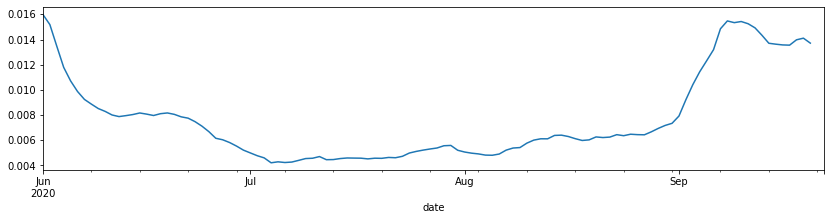

In [116]:
overview_data.index = pd.to_datetime(overview_data[date])
overview_data.sort_index(inplace=True)
smoothed_overview_data = overview_data.rolling(window=7).mean()
cases_per_test = (smoothed_overview_data[new_cases_by_specimen_date] / smoothed_overview_data[new_tests_by_publish_date])
cases_per_test.loc['2020-06-01':].plot(figsize=(14,3))
plt.gcf().set_facecolor('white')

In [110]:
nation_data = query(
    filters={area_type: nation}, 
    structure=[release_timestamp, date, area_name, area_code, new_cases_by_specimen_date, new_deaths_by_death_date]
)
nation_data

,releaseTimestamp,date,areaName,areaCode,newCasesBySpecimenDate,newDeaths28DaysByDeathDate
0,2020-09-22,2020-09-22,England,E92000001,NaN,NaN
1,2020-09-22,2020-09-21,England,E92000001,60.0,3.0
2,2020-09-22,2020-09-20,England,E92000001,1441.0,19.0
3,2020-09-22,2020-09-19,England,E92000001,2834.0,15.0
4,2020-09-22,2020-09-18,England,E92000001,3772.0,19.0
...,...,...,...,...,...,...
1051,2020-09-22,2020-01-07,Wales,W92000004,NaN,NaN
1052,2020-09-22,2020-01-06,Wales,W92000004,NaN,NaN
1053,2020-09-22,2020-01-05,Wales,W92000004,NaN,NaN
1054,2020-09-22,2020-01-04,Wales,W92000004,NaN,NaN


In [111]:
pickle('nation', nation_data)

'~/Downloads/phe_nation_2020-09-22_2020-09-22-17-49.pickle'

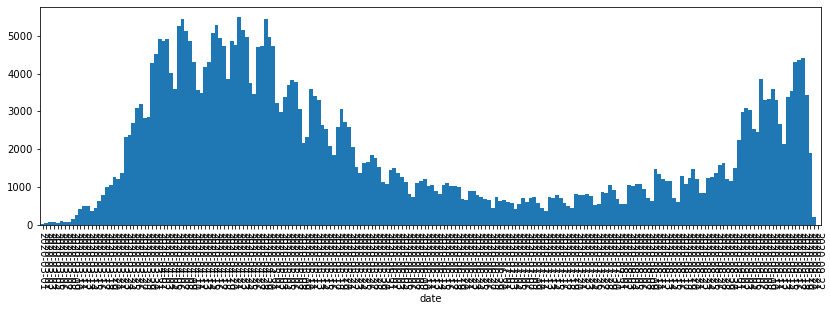

In [112]:
nation_data.groupby(date).sum()[new_cases_by_specimen_date].loc['2020-03-01':].plot(kind='bar', stacked=True, width=1, rot=-90, figsize=(14, 4))

In [113]:
area_data = query(
    filters={area_type: ltla}, 
    structure=[release_timestamp, date, area_name, area_code, new_cases_by_specimen_date, new_deaths_by_death_date],
    max_workers=10
)
area_data

,releaseTimestamp,date,areaName,areaCode,newCasesBySpecimenDate,newDeaths28DaysByDeathDate
0,2020-09-22,2020-09-22,Aberdeen City,S12000033,3.0,None
1,2020-09-22,2020-09-21,Aberdeen City,S12000033,4.0,None
2,2020-09-22,2020-09-20,Aberdeen City,S12000033,13.0,None
3,2020-09-22,2020-09-19,Aberdeen City,S12000033,12.0,None
4,2020-09-22,2020-09-18,Aberdeen City,S12000033,6.0,None
...,...,...,...,...,...,...
100995,2020-09-22,2020-05-06,Telford and Wrekin,E06000020,19.0,None
100996,2020-09-22,2020-05-05,Telford and Wrekin,E06000020,9.0,None
100997,2020-09-22,2020-05-04,Telford and Wrekin,E06000020,7.0,None
100998,2020-09-22,2020-05-03,Telford and Wrekin,E06000020,6.0,None


In [114]:
pickle('area', area_data)

'~/Downloads/phe_area_2020-09-22_2020-09-22-17-52.pickle'